
The Household energy dataset describes the usage patterns of the electricity consumption during 2016-2018.Dataset is a csv file
consisting of date, duration(time), cost, units(kwh) which illustarates the energy usage per day at 15 min duration with respective units consumed and cost. 

In [3]:
import matplotlib.pyplot as plt
import numpy as np 
import os 
import datetime
import pandas as pd 
from pandas import ExcelWriter
from pandas import ExcelFile

In [4]:
# read the data
cd=os.getcwd()
energy_data=pd.read_excel(cd+"\\D202.xlsx",  parse_dates = [["DATE","START TIME"]])
energy_data.head()

,DATE_START TIME,TYPE,END TIME,USAGE,UNITS,COST,NOTES
0,2016-10-22 00:00:00,Electric usage,00:14:00,0.01,kWh,0.0,NaN
1,2016-10-22 00:15:00,Electric usage,00:29:00,0.01,kWh,0.0,NaN
2,2016-10-22 00:30:00,Electric usage,00:44:00,0.01,kWh,0.0,NaN
3,2016-10-22 00:45:00,Electric usage,00:59:00,0.01,kWh,0.0,NaN
4,2016-10-22 01:00:00,Electric usage,01:14:00,0.01,kWh,0.0,NaN


In [5]:
energy_data.columns

Index(['DATE_START TIME', 'TYPE', 'END TIME', 'USAGE', 'UNITS', 'COST',
       'NOTES'],
      dtype='object')

In [6]:
#create the weekday column form the date
energy_data['weekday']=energy_data['DATE_START TIME'].dt.weekday_name
energy_data.head()

,DATE_START TIME,TYPE,END TIME,USAGE,UNITS,COST,NOTES,weekday
0,2016-10-22 00:00:00,Electric usage,00:14:00,0.01,kWh,0.0,NaN,Saturday
1,2016-10-22 00:15:00,Electric usage,00:29:00,0.01,kWh,0.0,NaN,Saturday
2,2016-10-22 00:30:00,Electric usage,00:44:00,0.01,kWh,0.0,NaN,Saturday
3,2016-10-22 00:45:00,Electric usage,00:59:00,0.01,kWh,0.0,NaN,Saturday
4,2016-10-22 01:00:00,Electric usage,01:14:00,0.01,kWh,0.0,NaN,Saturday


In [48]:
# energy_data.dtypes
energy_data['USAGE'].size
# energy_data.size

70368

In [8]:
# Create an index and resample the data

energy_data.index=pd.to_datetime(energy_data['DATE_START TIME'])

avg_usage=energy_data['USAGE'].resample("3H").mean()
avg_cost=energy_data['COST'].resample("3H").mean()
avg_usage.head()
avg_cost.head()
# hr= pd.timedelta_range(DATE_START TIME, freq="H")

DATE_START TIME
2016-10-22 00:00:00    0.000000
2016-10-22 03:00:00    0.000000
2016-10-22 06:00:00    0.000000
2016-10-22 09:00:00    0.003333
2016-10-22 12:00:00    0.010000
Freq: 3H, Name: COST, dtype: float64

### Visualization

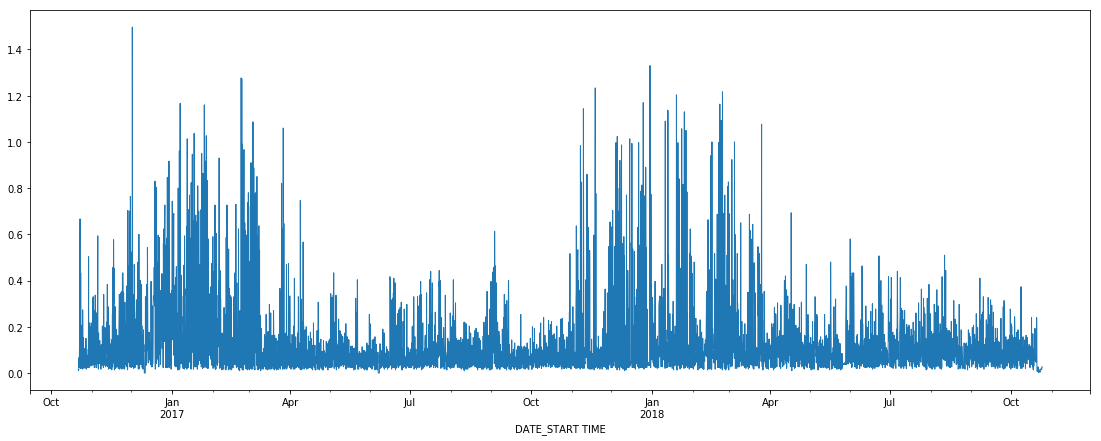

In [9]:
# Plot the data
from pandas import Series
import seaborn as sns
avg_usage.plot.line(figsize=(19,7), linewidth=1)

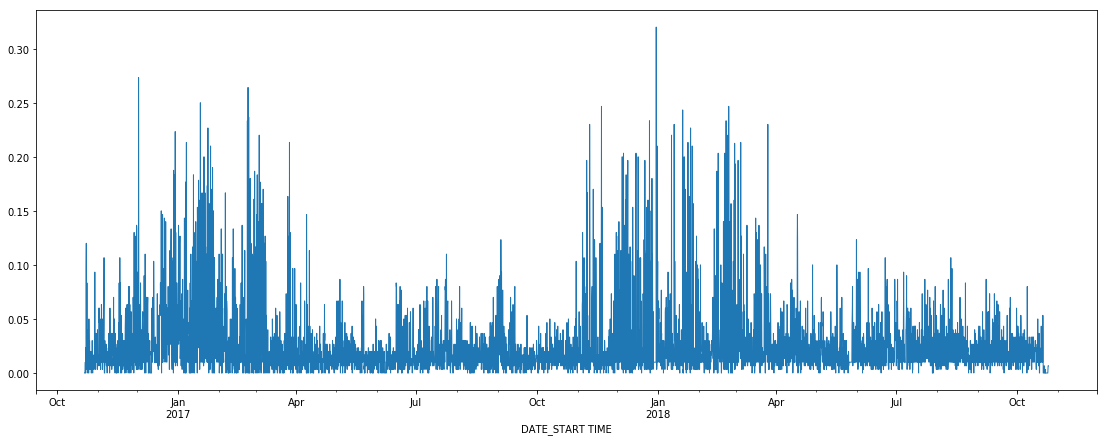

In [10]:
avg_cost.plot.line(figsize=(19,7), linewidth=1)

In [11]:
#Group the usage and cost by weekday
mean_data= energy_data[['weekday','USAGE','COST']].groupby('weekday').mean()
mean_data

,USAGE,COST
weekday,,
Friday,0.119884,0.024190
Monday,0.120813,0.024312
Saturday,0.134044,0.027202
Sunday,0.141234,0.028473
Thursday,0.114175,0.023378
Tuesday,0.112063,0.022574
Wednesday,0.111278,0.022639


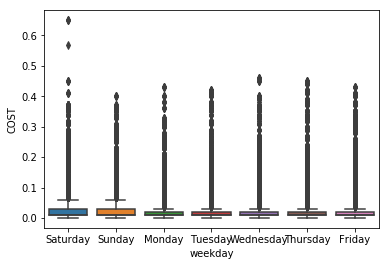

In [12]:
sns.boxplot(data=energy_data, x='weekday', y='COST')

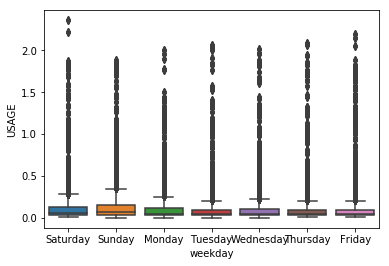

In [13]:
sns.boxplot(data=energy_data, x='weekday', y='USAGE')

##### A date_time index is created to gorup tha data by time in 3 hours interval. By averaging usage and cost in 3 hr inteval and plotting the time series data, we can observe that the data is having seasonality. Both the usage and cost exhibit seasonality, where the pattern is repeated at regula time intervals. The time series oscillates between the high and low values on quarterly time scale, corresponding the seasonal changes in weather over the year.
 - Electricity consumption is highest in winter, presumably due to electric heating and increased lighting usage and vacation season.
 - And also usage reaches its lowest values in spring and summer, due to abundant sunlight, outdoor living.
 - From boxplots, it is noticed that usage is hgher in weekends than compared to weekdays. Representing houshold  energy consumption, it significantly shows that there is  lower  usage in business days  in comparison with holidays.
 - The outliers in the weekdays are presumably during Holidays on weekdays.

### Usage forcasting- ARIMA Model
Being a seasonal data, it is clear that there is no stationarity in the data. Prior to building the model, convert the time series to stationary.

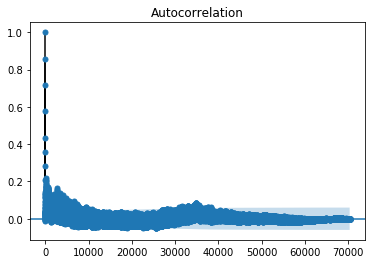

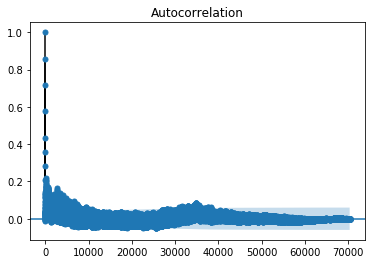

In [14]:
## stationary Conversion
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(energy_data['USAGE'])

In [15]:
energy_data['USAGE'].shift(1)
#differentiation
usage_diff= energy_data['USAGE'].diff(periods=1)
usage_diff[1:].head()

DATE_START TIME
2016-10-22 00:15:00    0.0
2016-10-22 00:30:00    0.0
2016-10-22 00:45:00    0.0
2016-10-22 01:00:00    0.0
2016-10-22 01:15:00    0.0
Name: USAGE, dtype: float64

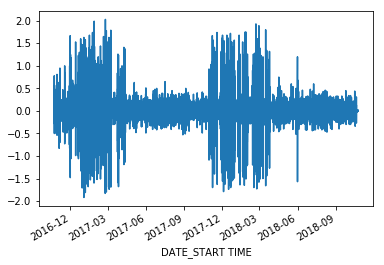

In [16]:
usage_diff.plot()

##### Now,plot exibits staionarity, which is good enough to build the ARIMA model.Stationarity is acheived by integrating by order of 1,with a difference fuction (d)

In [27]:
energy_data= energy_data.reset_index(drop=True)

In [61]:
## Splitting the data set


split= int(len(energy_data['USAGE']) * 0.8)
train, test = energy_data['USAGE'][0:split], energy_data['USAGE'][split:]
# train.size

# energy_data
energy_data['USAGE'].size

70368

In [57]:
# AR MODEL
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

model_ar= AR((train))
model_ar_fit= model_ar.fit()


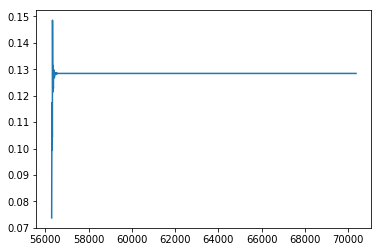

In [62]:
prediction=[]
prediction= model_ar_fit.predict(start=56294, end=70368 ) 
plt.plot(prediction)
# start= 2018-5-31, end=2018-10-24
# plt.plot(prediction[450352:562944], color='red')

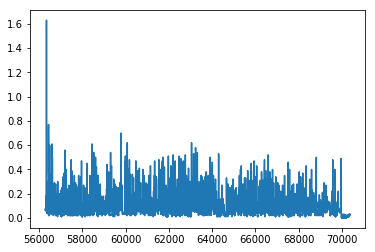

In [64]:
plt.plot(test)

In [66]:
# ARIMA Model
from statsmodels.tsa.arima_model import ARIMA
model_arima= ARIMA(train, order=(9,2,1))
arima_fit= model_arima.fit()
print(arima_fit.aic)

C:\Users\Poojitha\Anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


-84166.09740861054


In [67]:
arima_pred= arima_fit.forecast(steps=14074)[0]
arima_pred

array([ 0.06530843,  0.06213731,  0.14802727, ..., -0.50429096,
       -0.50436542, -0.50443989])

In [68]:
mean_squared_error(test,arima_pred )

0.08577575628148001

##### The goal is to acheive lower Mean Square error values, which is obtained 0.085. This states that test and predicted values consists of minimum difference proving the model has attained its optimal performance.